# Programming Assignment 1
## Linear Regression and Polynomial Regression

Aluno: Francisco Edyvalberty Alenquer Cordeiro \
Matrícula: 518659


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import linalg # QR DECOMPOSITION

# Utility Functions

## Metrics

In [2]:
def get_mse(y_real, y_pred):
    return np.mean((y_real - y_pred) ** 2)

def get_rmse(y_real, y_pred):
    return np.sqrt(get_mse(y_real, y_pred))

## Standardization

In [3]:
class StandardScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.mean = data.mean(axis=0)
        self.std = data.std(axis=0)
        self.fitted = True

        scaled_data = (data - self.mean) / self.std
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data = (data - self.mean) / self.std
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (scaled_data * self.std) + self.mean
        return original_data


## Min-max feature scaling

In [4]:
class MinMaxScaler:
    def __init__(self):
        self.fitted = False

    def fit_transform(self, data):      
        self.maximum = data.max(axis=0)
        self.minimum = data.min(axis=0)
        self.fitted = True

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data
    
    def transform(self, data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')

        scaled_data =  (data - self.minimum) / (self.maximum - self.minimum)
        return scaled_data

    def inverse_transform(self, scaled_data):
        if not self.fitted:
            raise Exception('Scaler not fitted!')
        
        original_data = (self.maximum - self.minimum) * scaled_data + self.minimum
        return original_data

# Task 1

In [5]:
data = np.genfromtxt('../data/artificial1d.csv', delimiter=',')
data[:5,:]

array([[-1.        , -2.08201726],
       [-0.93103448, -1.32698023],
       [-0.86206897, -1.10559772],
       [-0.79310345, -0.87394576],
       [-0.72413793, -0.28502695]])

## My Linear Regression

In [6]:
class MyLinearRegression:
    def __init__(self):
        self.fitted = False

    # Fit with OLS
    def fit_ols(self, X, y):
        matrix_to_mitigate_numerical_problems = (10 ** -8) * np.eye(X.shape[1], X.shape[1])
        w_hat = (np.linalg.pinv(X.T @ X + matrix_to_mitigate_numerical_problems) @ X.T) @ y
        self.w = w_hat.reshape(-1, 1)
        self.fitted = True

    # Fit with OLS using QR Decomposition
    def fit_ols_with_qr_decomp(self, X, y):
        Q, R = np.linalg.qr(X) 
        right_side_of_equation = Q.T @ y
        self.w = scipy.linalg.solve_triangular(R, right_side_of_equation)
        self.fitted = True


    # Fit with gradient descent
    def fit_gd(self, X, y, alpha=0.01, n_iterations=1000, random_state=151477):
        self.fitted = True
        
        rnd = np.random.RandomState(random_state)
        self.w = rnd.uniform(0, 1, X.shape[1]).reshape(-1, 1)        
        self.learning_curve = []

        for i in range(n_iterations):
            y_pred = self.predict(X)
            e = (y - y_pred) 
            self.w = self.w + ((1/len(y)) * alpha * (e.T @ X)).reshape(-1, 1)
            
            y_pred = self.predict(X)
            self.learning_curve.append(get_mse(y, y_pred))


    # Fit with stochastic gradient descent
    def fit_sgd(self, X, y, alpha=0.01, n_iterations=1000, random_state=151477):
        self.fitted = True
        
        rnd = np.random.RandomState(random_state)
        self.w = rnd.uniform(0, 1, X.shape[1]).reshape(-1, 1)

        self.learning_curve = []
        for i in range(n_iterations):
            
            chosen_index = rnd.randint(0, X.shape[0])
            random_X = X[[chosen_index]]
            random_y = y[[chosen_index]]

            y_pred = self.predict(random_X)
            e = (random_y - y_pred)
            self.w = self.w + (alpha * (e.T * random_X)).reshape(-1, 1)

            self.learning_curve.append(get_mse(y, self.predict(X)))

    
    def predict(self, X):
        if self.fitted:
            return (X @ self.w).reshape(-1, 1)
        else:
            raise Exception('Model not fitted!')


    def print_parameters(self):
        if self.fitted:
            for i in range(len(self.w)):
                if i == 0:
                    print('Intercept:\t{:.6f}'.format(self.w[i, 0]))
                else:
                    print('X({}):    \t{:.6f}'.format(i, self.w[i, 0]))
        else:
            raise Exception('Model not fitted!')


## Item a) OLS
Show the model parameters and the MSE (Mean Squared Error) obtained by OLS (Ordinary Least Squares) method. Plot the result line over the data.

In [7]:
X = np.hstack([np.ones((len(data), 1)), data[:,[0]]])
y = data[:,[1]]

In [8]:
my_lr = MyLinearRegression()
my_lr.fit_ols(X, y) # OLS
y_pred = my_lr.predict(X)

my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))


Intercept:	0.067618
X(1):    	1.574865

#--- Metrics ---#
MSE: 0.2134009013293699
RMSE: 0.461953354062258


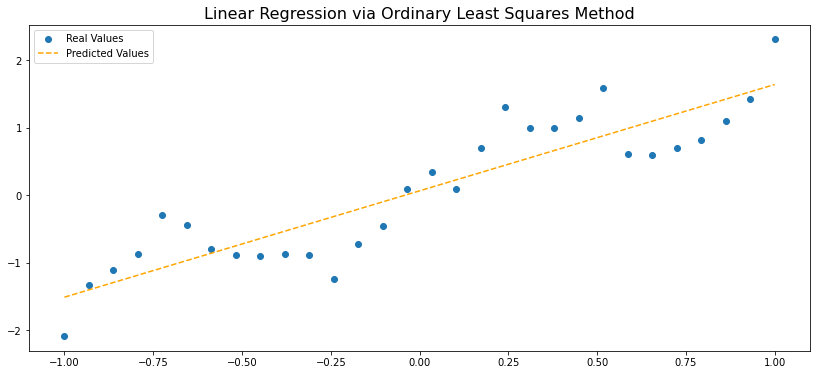

In [9]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Ordinary Least Squares Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

### OLS with QR Decomposition
When m $\gg$ n, we can use QR Decomposition to mitigate numerical problems of matrix inversion in standard formula of OLS (Normal Equation). $\\$
Doing the substitution $\boldsymbol{X} = \boldsymbol{QR}$, where $\boldsymbol{Q}^{\top}\boldsymbol{Q} = \boldsymbol{I}$ and $\boldsymbol{R}$ is a upper triangular matrix, we have the result as follows:$\\$
$$\begin{aligned}
\hat{\boldsymbol{w}} = (\boldsymbol{X}^{\top}\boldsymbol{X})^{-1} \boldsymbol{X}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{(QR)}^{\top}\boldsymbol{(QR)})^{-1} \boldsymbol{(QR)}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{QR})^{-1} \boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = (\boldsymbol{R}^{\top}\boldsymbol{R})^{-1} \boldsymbol{R}^{\top}\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = \boldsymbol{R}^{-1}(\boldsymbol{R}^{\top^{-1}}\boldsymbol{R}^{\top})\boldsymbol{Q}^{\top}\boldsymbol{y} \\
\hat{\boldsymbol{w}} = \boldsymbol{R}^{-1}\boldsymbol{Q}^{\top}\boldsymbol{y}  \text{  or  }  \boldsymbol{R}\hat{\boldsymbol{w}} = \boldsymbol{Q}^{\top}\boldsymbol{y}\\
\end{aligned}$$

In [10]:
X = np.hstack([np.ones((len(data), 1)), data[:,[0]]])
y = data[:,[1]]

In [11]:
my_lr = MyLinearRegression()
my_lr.fit_ols_with_qr_decomp(X, y) #OLS with QR Decomposition
y_pred = my_lr.predict(X)

my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.067618
X(1):    	1.574865

#--- Metrics ---#
MSE: 0.21340090132936987
RMSE: 0.46195335406225796


## Item b) Gradient Descent
Show the model parameters, the MSE and the learning curve obtained by Gradient Descent method. Plot the result line over the data.

In [12]:
X = np.hstack([np.ones((data.shape[0], 1)), data[:, [0]]])
y = data[:, [1]]

In [13]:
my_lr = MyLinearRegression()
my_lr.fit_gd(X, y, alpha=0.01, n_iterations=2000) # Gradient Descent
y_pred = my_lr.predict(X)
learning_curve_gd = my_lr.learning_curve
my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.067618
X(1):    	1.573632

#--- Metrics ---#
MSE: 0.21340144355295884
RMSE: 0.46195394094320574


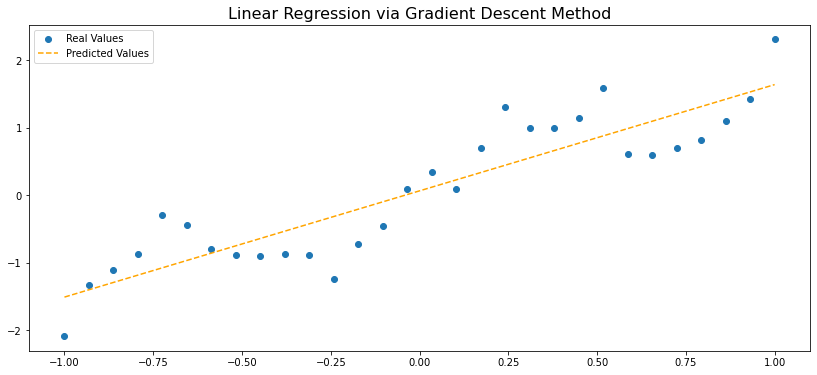

In [14]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Gradient Descent Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

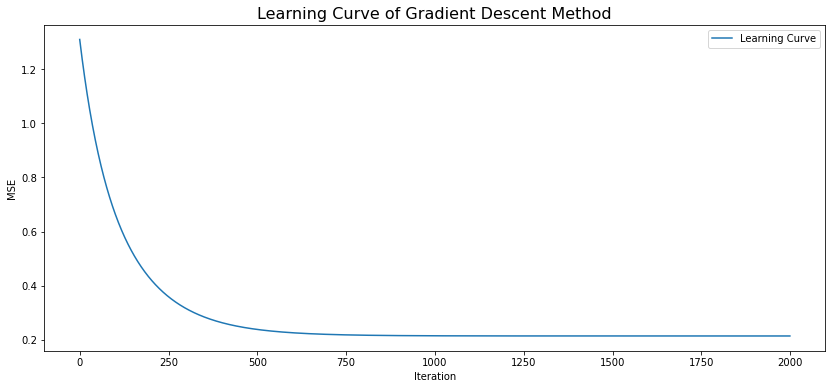

In [15]:
fig = plt.figure(figsize=(14, 6))
plt.title('Learning Curve of Gradient Descent Method', fontsize=16)
plt.plot(learning_curve_gd, label='Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Item c) Stochastic Gradient Descent
Show the model parameters, the MSE and the learning curve obtained by Stochastic Gradient Descent method. Plot the result line over the data.

In [16]:
# TODO - CORRIGIR ITERAÇÕES DO SGD
X = np.hstack([np.ones((data.shape[0], 1)), data[:, [0]]])
y = data[:, [1]]

In [17]:
my_lr = MyLinearRegression()
my_lr.fit_sgd(X, y, alpha=0.01, n_iterations=2000) # Stochastic Gradient Descent
y_pred = my_lr.predict(X)
learning_curve_sgd = my_lr.learning_curve
my_lr.print_parameters()

print('\n#--- Metrics ---#')
print('MSE:', get_mse(y, y_pred))
print('RMSE:', get_rmse(y, y_pred))

Intercept:	0.027689
X(1):    	1.568872

#--- Metrics ---#
MSE: 0.21500802345995013
RMSE: 0.4636895766134388


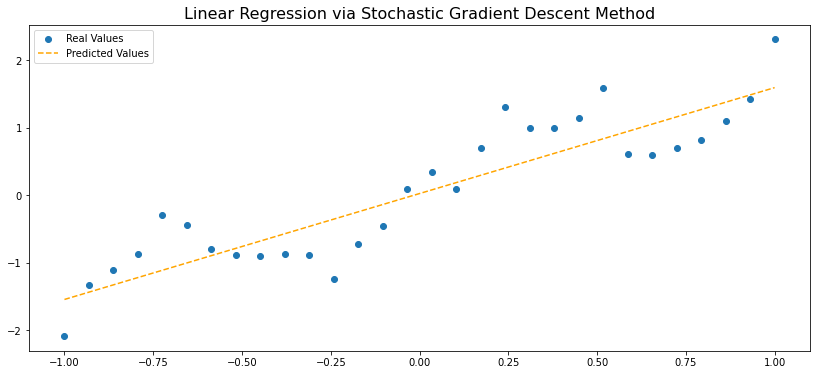

In [18]:
fig = plt.figure(figsize=(14, 6))
plt.title('Linear Regression via Stochastic Gradient Descent Method', fontsize=16)
plt.scatter(X[:, 1], y, label = 'Real Values')
plt.plot(X[:, 1], y_pred, c='orange', linestyle='--', label = 'Predicted Values')
plt.legend()
plt.show()

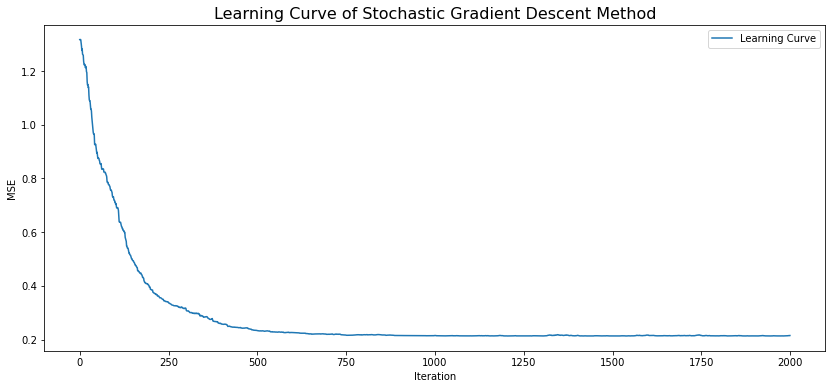

In [19]:
fig = plt.figure(figsize=(14, 6))
plt.title('Learning Curve of Stochastic Gradient Descent Method', fontsize=16)
plt.plot(learning_curve_sgd, label='Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.show()

## GD x SGD - Learning Curves Compare

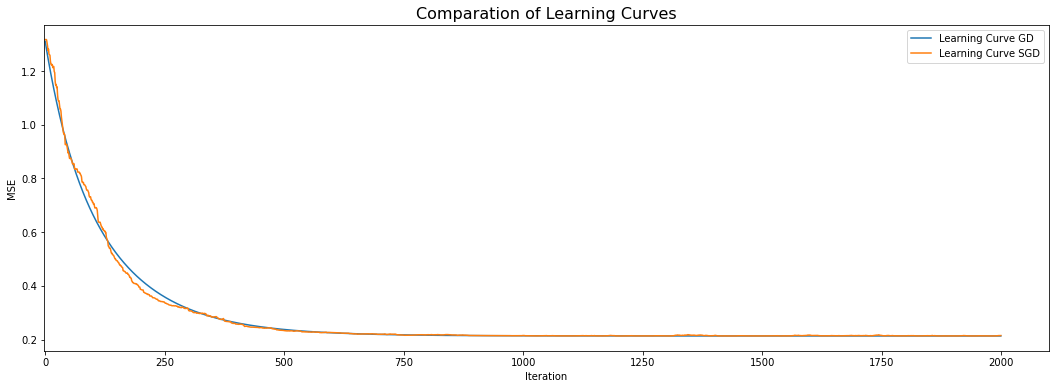

In [20]:
fig = plt.figure(figsize=(18, 6))
plt.title('Comparation of Learning Curves', fontsize=16)
plt.plot(learning_curve_gd, label='Learning Curve GD')
plt.plot(learning_curve_sgd, label='Learning Curve SGD')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.xlim(-2)
plt.legend()
plt.show()

# Task 2
Consider the dataset available in california.csv, organized into 9 columns, the 8 first being the independent variables (features) and the last column the dependent variable (target).
The dependent variables are used to predict the median of house prices in California districts in the 1990s.

- a) Randomly split the dataset in training (80%) and test (20%) 
- b) Train 11 polynomial regression models, with degrees from 1 to 11. You can you OLS algorithm to do this task.
- c) Report the RMSE of train and test for each model. Plot one chart to train and one chart to test.
- d) Repeat the previous 2 itens including the regularization term L2 (eg with factor λ = 0.001)

In [21]:
class MyPolynomialRegression:
    def __init__(self, polynomial_degree):
        self.polynomial_degree = polynomial_degree
        self.fitted = False


    def insert_polynomial_features(self, X):
        intercept = X[:, [0]]
        features = X[:, 1:]

        X_poly = features
        if self.polynomial_degree > 1:
            for i in range(2, self.polynomial_degree+1):
                X_poly = np.hstack([X_poly, features**i])
        
        X_poly = np.hstack([intercept, X_poly])

        return X_poly


    # Fit with OLS
    def fit_ols(self, X, y, reg_lambda=0):
        if not all(X[:, 0] == 1):
            raise Exception('The first column must be the intercept column (X[0])')

        X = self.insert_polynomial_features(X)

        self.X_scaler = StandardScaler()
        X = np.hstack([X[:, [0]], self.X_scaler.fit_transform(X[:, 1:])])
        self.y_scaler = StandardScaler()
        y = self.y_scaler.fit_transform(y)

        matrix_to_mitigate_numerical_problems = (10 ** -8) * np.eye(X.shape[1], X.shape[1])
        reg_matrix = np.eye(X.shape[1], X.shape[1]) * reg_lambda
        reg_matrix[0, 0] = 0

        w_hat = (np.linalg.pinv(X.T @ X + reg_matrix + matrix_to_mitigate_numerical_problems) @ X.T) @ y
        self.w = w_hat.reshape(-1, 1)
        self.fitted = True


    def predict(self, X):
        if self.fitted:
            if not all(X[:, 0] == 1):
                raise Exception('The first column must be the intercept column (X[0])')
            
            X = self.insert_polynomial_features(X)
            X = np.hstack([X[:, [0]], self.X_scaler.transform(X[:, 1:])])

            y_pred = (X @ self.w).reshape(-1, 1)
            y_pred = self.y_scaler.inverse_transform(y_pred)

            return y_pred
        else:
            raise Exception('Model not fitted!')


In [22]:
california_data = np.genfromtxt('../data/california.csv', delimiter=',')

print('Visualizing data')
california_data[:2,:]

Visualizing data


array([[   4.1685    ,   20.        ,    6.70063694,    1.17834395,
         745.        ,    2.37261146,   38.8       , -121.15      ,
           2.175     ],
       [   2.8194    ,   24.        ,    4.7625    ,    1.02083333,
         608.        ,    2.53333333,   36.75      , -119.85      ,
           0.811     ]])

In [23]:
def train_test_split(data, train_size_perc, random_seed=264852):
    N = data.shape[0]
    train_size = int(train_size_perc * N)

    indexes = np.arange(0, N, 1)

    np.random.seed(random_seed)
    train_idx = np.random.choice(indexes, train_size, replace=False)
    test_idx = np.delete(indexes, train_idx)

    train_data = data[train_idx]
    test_data = data[test_idx]

    X_train = train_data[:,:-1]
    y_train = train_data[:,[-1]]

    X_test = test_data[:,:-1]
    y_test = test_data[:,[-1]]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(california_data, 0.8)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (4000, 8)
y_train shape: (4000, 1)
X_test shape: (1000, 8)
y_test shape: (1000, 1)


## Without Regularization

In [24]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(get_rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(get_rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [25]:
print('Polynomial Regression')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942386      0.669167        
3       0.63777556      0.783326        
4       0.63049649      1.496323        
5       0.62816813      1.116712        
6       0.62620750      1.514245        
7       0.62128935      113.901037      
8       0.62020693      732.427300      
9       0.62019547      839.689869      
10      0.62005297      159.077822      
11      0.61955820      2661.916207     


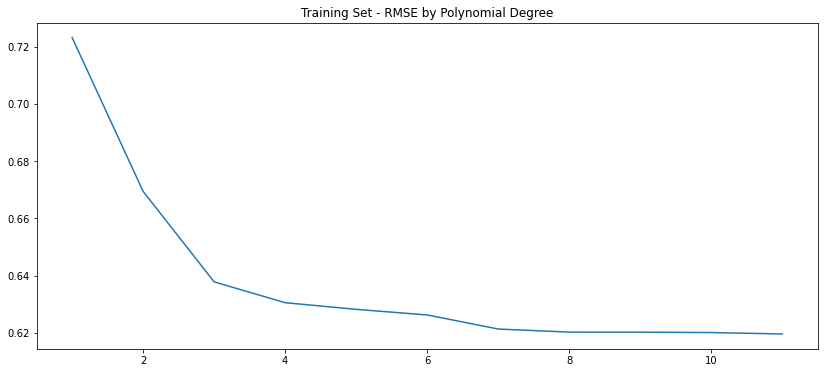

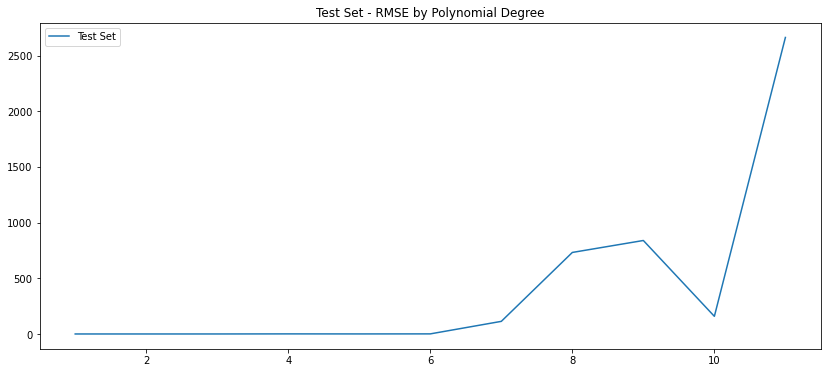

In [29]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()

## With Regularization (lambda=0.001)

In [30]:
rmse_train_list = []
rmse_test_list = []

for i in range(11):
    my_poly_reg = MyPolynomialRegression(polynomial_degree=i+1)

    # Training model
    X_train_temp = np.hstack([np.ones((len(X_train),1)), X_train])
    my_poly_reg.fit_ols(X_train_temp, y_train, reg_lambda=0.001)

    # Predicting y_train
    y_train_pred = my_poly_reg.predict(X_train_temp)
    rmse_train_list.append(get_rmse(y_train, y_train_pred))

    # Predicting y_test
    X_test_temp = np.hstack([np.ones((len(X_test),1)), X_test])
    y_test_pred = my_poly_reg.predict(X_test_temp)
    rmse_test_list.append(get_rmse(y_test, y_test_pred))

rmse_train_list = np.array(rmse_train_list)
rmse_test_list = np.array(rmse_test_list)

In [31]:
print('Polynomial Regression with L2 Regularization (lambda=0.001)')
print('----------------------------------')
print('Degree\tRMSE(Training)\tRMSE(Test)')
print('----------------------------------')
for i, row in enumerate(zip(rmse_train_list, rmse_test_list)):
    print('{0:<8}{1:<16.8f}{2:<16.6f}'.format(i+1, row[0], row[1]))

Polynomial Regression with L2 Regularization (lambda=0.001)
----------------------------------
Degree	RMSE(Training)	RMSE(Test)
----------------------------------
1       0.72322157      0.720783        
2       0.66942424      0.669181        
3       0.65069351      0.768951        
4       0.64674961      1.418320        
5       0.64495673      0.837795        
6       0.64441665      1.124933        
7       0.64404116      8.969059        
8       0.64318765      31.159555       
9       0.64206431      72.894065       
10      0.64124400      129.035566      
11      0.64088871      168.668157      


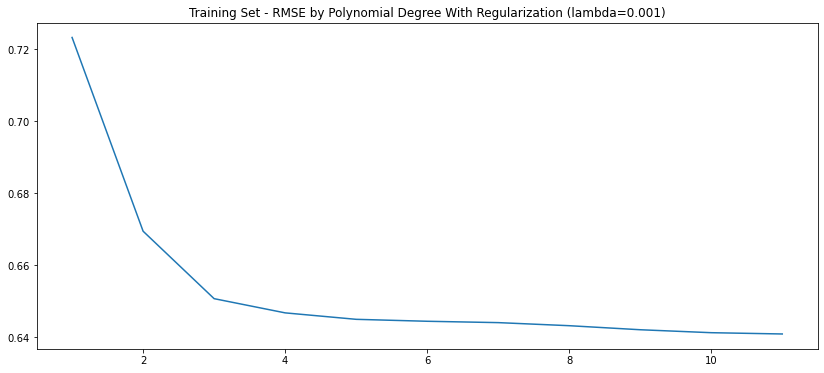

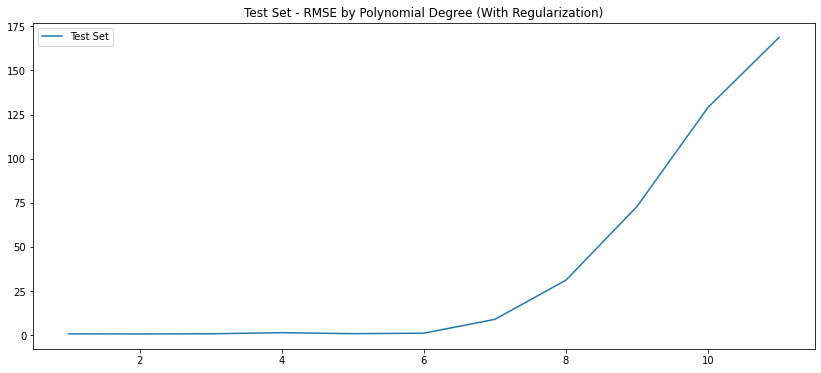

In [33]:
plt.figure(figsize=(14,6))
plt.title('Training Set - RMSE by Polynomial Degree With Regularization (lambda=0.001)')
plt.plot(range(1,12), rmse_train_list, label='Training Set')
plt.figure(figsize=(14,6))
plt.title('Test Set - RMSE by Polynomial Degree (With Regularization)')
plt.plot(range(1,12), rmse_test_list, label='Test Set')
plt.legend()
plt.show()